### Cell 1: Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Cell 2: Data Cleaning Function

In [2]:
def load_and_clean_data(file_path):
    try:
        # Load raw data
        df = pd.read_csv(file_path)
        
        # Fix header issue: District names are in row 0
        district_cols = df.iloc[0, 14:].dropna().values
        new_cols = list(df.columns[:14]) + list(district_cols)
        
        df_data = df.iloc[1:].copy()
        df_data = df_data.iloc[:, :len(new_cols)]
        df_data.columns = new_cols
        
        # Convert numeric columns
        num_cols = ['SOIL_PH_LOW', 'SOIL_PH_HIGH', 'CROPDURATION_MIN', 'CROPDURATION_MAX', 
                    'MIN_TEMP', 'MAX_TEMP', 'WATER REQUIRED_MIN', 'WATERREQUIRED_MAX', 
                    'RELATIVE_HUMIDITY_MIN', 'RELATIVE_HUMIDITY_MAX']
        
        for col in num_cols:
            df_data[col] = pd.to_numeric(df_data[col], errors='coerce')
            
        df_data.dropna(subset=num_cols, inplace=True)
        return df_data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

### Cell 3: Data Augmentation Function

In [3]:
def augment_data(df, samples_per_crop=200):
    augmented_data = []
    for _, row in df.iterrows():
        crop = row['CROPS']
        soil = row['SOIL']
        type_crop = row['TYPE_OF_CROP']
        water_source = row['TYPE_OF _WATERSOURCE']
        
        for _ in range(samples_per_crop):
            # Random sampling within the min-max ranges
            ph = np.random.uniform(row['SOIL_PH_LOW'], row['SOIL_PH_HIGH'])
            dur = np.random.uniform(row['CROPDURATION_MIN'], row['CROPDURATION_MAX'])
            temp = np.random.uniform(row['MIN_TEMP'], row['MAX_TEMP'])
            water = np.random.uniform(row['WATER REQUIRED_MIN'], row['WATERREQUIRED_MAX'])
            humid = np.random.uniform(row['RELATIVE_HUMIDITY_MIN'], row['RELATIVE_HUMIDITY_MAX'])
            
            augmented_data.append([crop, type_crop, soil, water_source, ph, dur, temp, water, humid])
            
    return pd.DataFrame(augmented_data, columns=['CROPS', 'TYPE_OF_CROP', 'SOIL', 'WATER_SOURCE', 
                                                 'PH', 'DURATION', 'TEMP', 'WATER', 'HUMIDITY'])

### Cell 4: Model Architectures

In [4]:
# --- Model Definitions ---

class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * (input_dim // 2), output_dim) 
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, 64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

class ResidualMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x1 = self.relu(self.fc1(x))
        x2 = self.relu(self.fc2(x1))
        x = x1 + x2
        x = self.fc3(x)
        return x

class Hybrid_CNNLSTM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Hybrid_CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### Cell 5: Data Pipeline Execution

In [5]:
# Define file path
file_path = 'Tamil Nadu - AgriData_Dist.csv' # Ensure this file exists in your directory

print(f"Loading data from {file_path}...")
df = load_and_clean_data(file_path)

if df is not None:
    print(f"Data loaded. Original rows: {len(df)}")
    print("Augmenting data (this may take a moment)...")
    aug_df = augment_data(df, samples_per_crop=200)
    print(f"Augmented rows: {len(aug_df)}")
    
    # --- Preprocessing ---
    le_dict = {}
    
    # Target Encoding
    le_crops = LabelEncoder()
    aug_df['CROPS_ENC'] = le_crops.fit_transform(aug_df['CROPS'])
    le_dict['CROPS'] = le_crops

    # Feature Encoding (Aligning names with app.py expectation)
    le_soil = LabelEncoder()
    aug_df['SOIL_ENC'] = le_soil.fit_transform(aug_df['SOIL'])
    le_dict['SOIL'] = le_soil

    le_type = LabelEncoder()
    aug_df['TYPE_ENC'] = le_type.fit_transform(aug_df['TYPE_OF_CROP'])
    le_dict['TYPE_OF_CROP'] = le_type

    le_source = LabelEncoder()
    aug_df['SOURCE_ENC'] = le_source.fit_transform(aug_df['WATER_SOURCE'])
    le_dict['WATER_SOURCE'] = le_source
        
    features = ['SOIL_ENC', 'TYPE_ENC', 'SOURCE_ENC', 'PH', 'DURATION', 'TEMP', 'WATER', 'HUMIDITY']
    
    X = aug_df[features].values
    y = aug_df['CROPS_ENC'].values
    
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
        
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)
    
    # Define Dimensions
    input_dim = X.shape[1]
    output_dim = len(le_dict['CROPS'].classes_)
    
    print("Data processing complete.")
else:
    print("Failed to load data. Please check file path.")

Loading data from Tamil Nadu - AgriData_Dist.csv...
Data loaded. Original rows: 105
Augmenting data (this may take a moment)...
Augmented rows: 21000
Data processing complete.


### Cell 6: Data Visualization (EDA)

Generating Exploratory Data Analysis (EDA) charts...


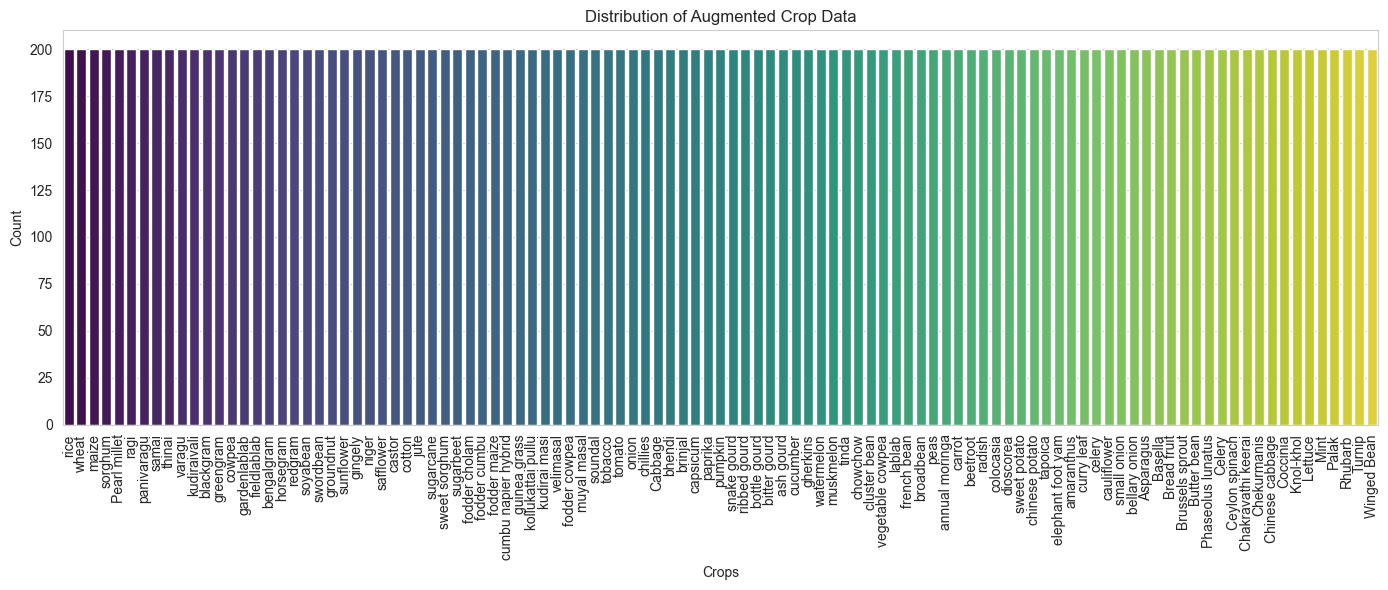

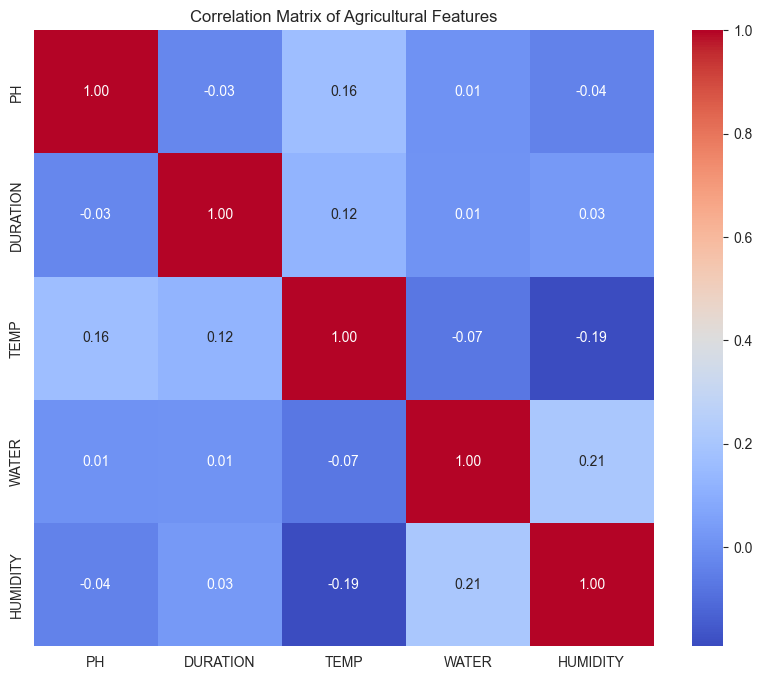

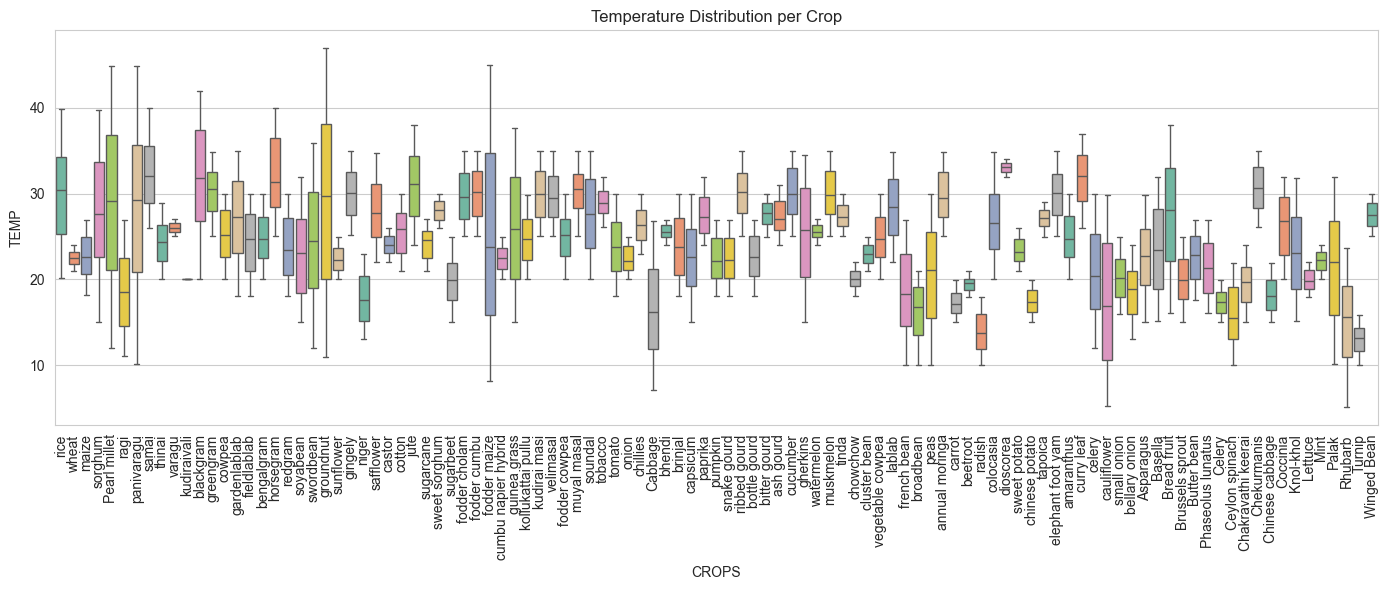

In [6]:
if df is not None:
    print("Generating Exploratory Data Analysis (EDA) charts...")

    # 1. Target Variable Distribution (Classes)
    plt.figure(figsize=(14, 6))
    # FIX: Added hue='CROPS' and legend=False
    sns.countplot(
        data=aug_df, 
        x='CROPS', 
        hue='CROPS', 
        legend=False, 
        palette='viridis', 
        order=aug_df['CROPS'].value_counts().index
    )
    plt.title("Distribution of Augmented Crop Data")
    plt.xticks(rotation=90)
    plt.xlabel("Crops")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 2. Correlation Matrix of Numerical Features
    numeric_cols = ['PH', 'DURATION', 'TEMP', 'WATER', 'HUMIDITY']
    plt.figure(figsize=(10, 8))
    sns.heatmap(aug_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Agricultural Features")
    plt.show()

    # 3. Boxplot of Temperature vs Crops
    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=aug_df, 
        x='CROPS', 
        y='TEMP', 
        hue='CROPS', 
        legend=False, 
        palette='Set2'
    )
    plt.xticks(rotation=90)
    plt.title("Temperature Distribution per Crop")
    plt.tight_layout()
    plt.show()

### Cell 7: Training Loop

In [7]:
if df is not None:
    models = {
        "CNN": CNNModel(input_dim, output_dim).to(device),
        "LSTM": LSTMModel(input_dim, output_dim).to(device),
        "GRU": GRUModel(input_dim, output_dim).to(device),
        "Transformer": TransformerModel(input_dim, output_dim).to(device),
        "ResidualMLP": ResidualMLP(input_dim, output_dim).to(device),
        "Hybrid_CNNLSTM": Hybrid_CNNLSTM(input_dim, output_dim).to(device)
    }
    
    metrics = {}
    history = {name: [] for name in models.keys()} # Store loss per epoch
    
    print("\n--- Starting Training Loop ---\n")
    for name, model in models.items():
        print(f"Training {name}...")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)
        
        model.train()
        epochs = 10 # Increased to 10 to see better curves
        for epoch in range(epochs): 
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                out = model(X_batch)
                loss = criterion(out, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Store average loss for this epoch
            history[name].append(epoch_loss / len(loader))
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_out = model(X_test_tensor)
            _, predicted = torch.max(test_out, 1)
            accuracy = (predicted == y_test_tensor).float().mean().item()
            metrics[name] = accuracy * 100
            print(f" > {name} Test Accuracy: {metrics[name]:.2f}%")


--- Starting Training Loop ---

Training CNN...
 > CNN Test Accuracy: 96.45%
Training LSTM...
 > LSTM Test Accuracy: 95.90%
Training GRU...
 > GRU Test Accuracy: 96.21%
Training Transformer...
 > Transformer Test Accuracy: 97.98%
Training ResidualMLP...
 > ResidualMLP Test Accuracy: 97.33%
Training Hybrid_CNNLSTM...
 > Hybrid_CNNLSTM Test Accuracy: 96.24%


### Cell 8: Model Performance Visualization

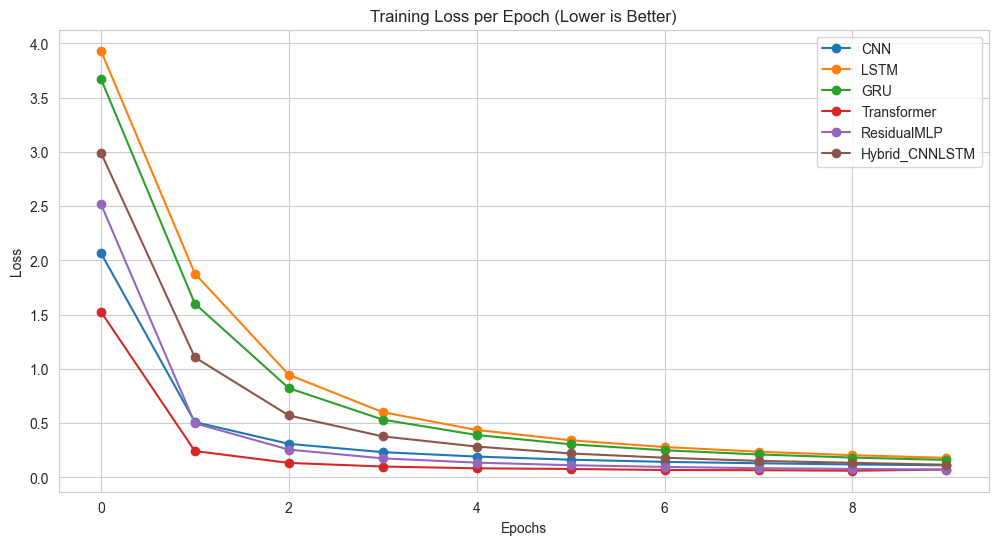

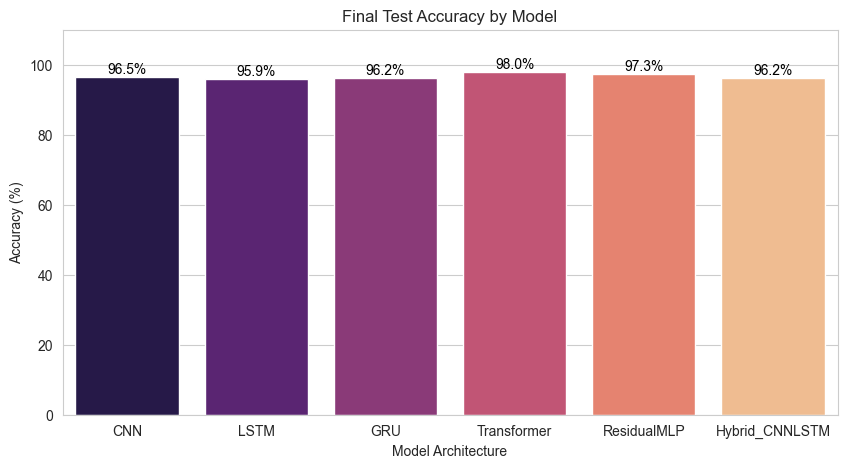

In [8]:
if df is not None:
    # 1. Learning Curves (Loss per Epoch)
    plt.figure(figsize=(12, 6))
    for name, loss_data in history.items():
        plt.plot(loss_data, label=name, marker='o')
    
    plt.title("Training Loss per Epoch (Lower is Better)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Model Accuracy Comparison Bar Chart
    names = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(10, 5))
    
    barplot = sns.barplot(x=names, y=values, hue=names, legend=False, palette="magma")
    
    # Add text labels on top of bars
    for i, v in enumerate(values):
        barplot.text(i, v + 1, f"{v:.1f}%", color='black', ha="center")

    plt.ylim(0, 110) # Set limit to 110 to give space for text
    plt.title("Final Test Accuracy by Model")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model Architecture")
    plt.show()

### Cell 9: Save Encoders and Models

In [9]:
if df is not None:
    # Save Encoders for app.py
    with open('encoders.pkl', 'wb') as f:
        pickle.dump({'encoders': le_dict, 'scaler': scaler}, f)
    print("Saved encoders.pkl")

    # Save metrics to JSON
    with open('model_metrics.json', 'w') as f:
        json.dump(metrics, f)
    print("Saved model_metrics.json")
    
    # Save PyTorch Models
    for name, model in models.items():
        torch.save(model.state_dict(), f"{name}_model.pth")
        print(f"Saved {name}_model.pth")

Saved encoders.pkl
Saved model_metrics.json
Saved CNN_model.pth
Saved LSTM_model.pth
Saved GRU_model.pth
Saved Transformer_model.pth
Saved ResidualMLP_model.pth
Saved Hybrid_CNNLSTM_model.pth


### Cell 10: Manual Prediction Test

In [10]:
if df is not None:
    print("\n--- Running Manual Prediction Test ---")
    
    # Pick the first actual row from the augmented dataframe to test
    sample_row = aug_df.iloc[0] 
    print(f"Testing with known data for crop: {sample_row['CROPS']}")
    
    # Construct sample input dictionary using raw values
    sample_input = {
        'SOIL': sample_row['SOIL'],
        'TYPE_OF_CROP': sample_row['TYPE_OF_CROP'],
        'WATER_SOURCE': sample_row['WATER_SOURCE'],
        'PH': sample_row['PH'],
        'DURATION': sample_row['DURATION'],
        'TEMP': sample_row['TEMP'],
        'WATER': sample_row['WATER'],
        'HUMIDITY': sample_row['HUMIDITY']
    }
    
    print(f"Input Features: {sample_input}")
    
    try:
        # Encoding Steps (Mirroring app.py)
        soil_enc = le_dict['SOIL'].transform([sample_input['SOIL']])[0]
        type_enc = le_dict['TYPE_OF_CROP'].transform([sample_input['TYPE_OF_CROP']])[0]
        source_enc = le_dict['WATER_SOURCE'].transform([sample_input['WATER_SOURCE']])[0]
        
        raw_features = np.array([[
            soil_enc, 
            type_enc, 
            source_enc, 
            sample_input['PH'], 
            sample_input['DURATION'], 
            sample_input['TEMP'], 
            sample_input['WATER'], 
            sample_input['HUMIDITY']
        ]])
        
        # Scale
        scaled_features = scaler.transform(raw_features)
        tensor_input = torch.FloatTensor(scaled_features).to(device)
        
        print("\nPredictions:")
        for name, model in models.items():
            model.eval()
            with torch.no_grad():
                logits = model(tensor_input)
                probs = torch.nn.functional.softmax(logits, dim=1)
                conf, pred_idx = torch.max(probs, 1)
                
                pred_crop = le_dict['CROPS'].inverse_transform([pred_idx.item()])[0]
                status = "✅ Correct" if pred_crop == sample_row['CROPS'] else "❌ Incorrect"
                print(f"  {name}: {pred_crop} (Conf: {conf.item()*100:.2f}%) - {status}")
                
    except Exception as e:
        print(f"Test failed: {e}")


--- Running Manual Prediction Test ---
Testing with known data for crop: rice
Input Features: {'SOIL': 'Alluvia or loamy and clayey soil', 'TYPE_OF_CROP': 'cereals', 'WATER_SOURCE': 'both', 'PH': np.float64(7.077420188108722), 'DURATION': np.float64(150.0), 'TEMP': np.float64(29.14555301244974), 'WATER': np.float64(2090.2985170529323), 'HUMIDITY': np.float64(78.78196191969587)}

Predictions:
  CNN: rice (Conf: 99.93%) - ✅ Correct
  LSTM: rice (Conf: 98.99%) - ✅ Correct
  GRU: rice (Conf: 98.87%) - ✅ Correct
  Transformer: rice (Conf: 99.95%) - ✅ Correct
  ResidualMLP: rice (Conf: 99.97%) - ✅ Correct
  Hybrid_CNNLSTM: rice (Conf: 98.96%) - ✅ Correct
